Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Brain tumor 3D segmentation with MONAI

## Setup imports

In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    Compose,
    LoadImaged,
    MapTransform,
    Orientationd,
    RandFlipd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    Spacingd,
    Resized,
    RandRotated,
    RandZoomd,
    RandAffined,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.nets import SwinUNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.utils.data as data
import numpy as np
import logging
from importlib import reload

# print_config()

/home/selab1623/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
root_dir = './data/PETCT/'
roi_size = (128,128,64)
print(root_dir)

./data/PETCT/


## Set dataset path

In [3]:
#leave-one-out cross validation data for pet-ct big tumor & normal patients
ours_images = sorted(glob.glob(root_dir+"train/ours/*petct.nii.gz"))
ours_labels = sorted(glob.glob(root_dir+"train/ours/*seg.nii.gz"))
ours_images_normal = sorted(glob.glob('./data/normal_petct/*petct.nii.gz'))
ours_labels_normal = sorted(glob.glob('./data/normal_petct/*mask.nii.gz'))
ours_data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(ours_images, ours_labels)]
ours_data_dicts_normal = [{"image": image_name, "label": label_name} for image_name, label_name in zip(ours_images_normal, ours_labels_normal)]
ours_data_dicts += ours_data_dicts_normal
loocv_files_set = []
for i in range(len(ours_data_dicts)):
    train_test_files = ours_data_dicts[:i]+ours_data_dicts[i+1:]
    test_files = [ours_data_dicts[i]]
    loocv_files_set.append([train_test_files, test_files])
fold_num = 1
loocv_test_files = loocv_files_set[fold_num-1][1]
print(len(train_test_files))
print(len(test_files))

30
1


## Define a new transform

In [38]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 4 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge labels 1, 2 and 4 to construct whole tumor
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 4), d[key] == 1))
            d[key] = torch.stack(result, axis=0).float()
        return d


class NormalizeFrom0to1(MapTransform):
  def __call__(self, data):
      d = dict(data)
      for key in self.keys:
          d[key] = (d[key] - torch.min(d[key])) / (torch.max(d[key]) - torch.min(d[key]))
      return d


class AdjustLabelValued(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key][d[key]<0.5] = 0
            d[key][d[key]>=0.5] = 1
        return d

import cv2        
def gradient(img):
    gradient_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    gradient_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

    gradient_x = np.absolute(gradient_x)
    gradient_y = np.absolute(gradient_y)

    # 合併x和y方向的梯度
    gradient_combined = cv2.addWeighted(gradient_x, 0.5, gradient_y, 0.5, 0)
    return torch.Tensor(gradient_combined)
    
class Derivateived(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            batch_size = d[key].shape[0]
            depth = d[key].shape[3]
            for i in range(batch_size):
                for j in range(depth):
                    d[key][i,:,:,j] = gradient(np.asarray(d[key][i,:,:,j]))
        return d
    
set_determinism(seed=0)

## Setup transforms for training and validation

In [39]:
train_transforms = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Resized(keys=["image", "label"],spatial_size=roi_size),        
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        Derivateived(keys="image"),
        AdjustLabelValued(keys="label"),
        NormalizeFrom0to1(keys="image"),
    ]
)

affine_transforms = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Resized(keys=["image", "label"],spatial_size=roi_size),
        RandAffined(keys=["image", "label"],prob=1.0,shear_range=(0.4,0.4),translate_range=(0.1,0.3)),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        AdjustLabelValued(keys="label"),
        NormalizeFrom0to1(keys="image"),
    ]
)

rot_transforms = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Resized(keys=["image", "label"],spatial_size=roi_size),
        RandRotated(keys=["image", "label"],range_z=[0.2,0.5],prob=1.0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        AdjustLabelValued(keys="label"),
        NormalizeFrom0to1(keys="image"),
    ]
)

zoom_transforms = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Resized(keys=["image", "label"],spatial_size=roi_size),
        RandZoomd(keys=["image", "label"],prob=1.0, min_zoom=0.6, max_zoom=0.9),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        AdjustLabelValued(keys="label"),
        NormalizeFrom0to1(keys="image"),
    ]
)

rot_zoom_transforms = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Resized(keys=["image", "label"],spatial_size=roi_size),
        RandZoomd(keys=["image", "label"],prob=1.0, min_zoom=0.6, max_zoom=0.9),
        RandRotated(keys=["image", "label"],range_z=[-0.2,-0.5],prob=1.0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        AdjustLabelValued(keys="label"),
        NormalizeFrom0to1(keys="image"),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Resized(keys=["image", "label"],spatial_size=roi_size),
        AdjustLabelValued(keys="label"),
        NormalizeFrom0to1(keys="image"),
    ]
)

## Check transforms in DataLoader

torch.Size([1, 1, 128, 128, 64])
torch.Size([1, 1, 128, 128, 64])
image shape: torch.Size([128, 128, 64]), label shape: torch.Size([128, 128, 64])
[0.         0.03451091 0.03907394 ... 0.99973816 0.99988645 1.        ]
[0. 1.]


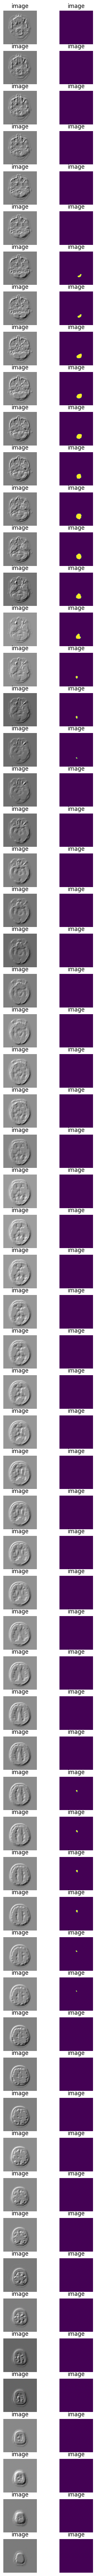

In [40]:
check_ds = Dataset(data=loocv_files_set[0][0], transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
print(check_data["image"].shape)
print(check_data["label"].shape)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(np.unique(image))
print(np.unique(label))
cols = 2
rows = image.shape[2]
fig = plt.figure("check", (4, 100))
for i in range(rows):
    fig.add_subplot(rows,cols,(i*cols)+1)
    plt.title("image")
    plt.imshow(image[:, :, i], cmap="gray")
    plt.axis('off')
    fig.add_subplot(rows,cols,(i*cols)+2)
    plt.title("image")
    plt.imshow(label[:, :, i])
    plt.axis('off')

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [ ]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
val_loader = DataLoader(val_ds, batch_size=1)
print(len(train_loader))
print(len(val_loader))

## Create Model, Loss, Optimizer

In [8]:
use_pretrained = False
pretrained_path = './SSL/models/01/best_model.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)

model = SwinUNETR(
    img_size=roi_size,
    in_channels=1,
    out_channels=2,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

No weights were loaded, all weights being used are randomly initialized!


## Load weights to continue training

In [ ]:
model.load_state_dict(torch.load('./brats2021_flair_240_240_64/models/swinunetr/transfer learning/swinunetr-best_metric_model.pth'))

## Execute a typical PyTorch training process

In [ ]:
max_epochs = 100
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

#reload logger
logging.shutdown()
reload(logging)
logging.basicConfig(filename=root_dir+'training_log.txt',filemode='a',format='%(message)s',level=logging.DEBUG)

for epoch in range(max_epochs,200):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_loader) // train_loader.batch_size}" f"-> train_loss: {loss.item():.4f}",end='| ')
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print('\n',f"epoch {epoch + 1} => average loss: {epoch_loss:.4f}",end='| ')

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = roi_size
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            print(
                f"mean dice: {metric:.4f}\n"
            )
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

            logging.info(f'Epoch {epoch + 1} - average loss: {epoch_loss:.4f} | mean dice: {metric:.4f}| best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}')

torch.save(model.state_dict(), os.path.join(root_dir, "last_model.pth"))

In [23]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
torch.save(model.state_dict(), os.path.join(root_dir, "last_model.pth"))

train completed, best_metric: 0.0006 at epoch: 1


## Plot the loss and metric

In [ ]:
plt.figure("train", (24, 6))
plt.subplot(1, 4, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(1, 4, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

## Inference on Test Set

In [11]:
test_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Resized(keys=["image", "label"],spatial_size=roi_size),
        AdjustLabelValued(keys="label"),
        NormalizeFrom0to1(keys="image"),
    ]
)

post_transforms = Compose(
    [
        AsDiscreted(keys="pred", argmax=True),
    ]
)

test_images = sorted(glob.glob('./data/normal_flair/*mri.nii.gz'))
test_labels = sorted(glob.glob('./data/normal_flair/*mask.nii.gz'))
# print(nib.load(test_images[0]).get_fdata().shape)
# test_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(test_images, test_labels)]
test_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(test_images, test_labels)]
test_org_ds = Dataset(data=test_files, transform=test_org_transforms)
test_org_loader = DataLoader(test_org_ds, batch_size=1)
check_data = first(test_org_loader)
print(check_data["image"].shape)
print(len(test_org_loader))

torch.Size([1, 1, 128, 128, 64])
22


In [ ]:
model.load_state_dict(torch.load(os.path.join('./data/brats2021_flair_240_240_64/last_model.pth')))
model.eval()
with torch.no_grad():
    for i in range(len(test_files)):
        test_file = [test_files[i]]
        test_org_ds = Dataset(data=test_file, transform=test_org_transforms)
        test_org_loader = DataLoader(test_org_ds, batch_size=1)
        for c, test_data in enumerate(test_org_loader):
            shape = test_data["image"].shape
            labelShape = test_data["label"].shape
            roi_size = roi_size
            sw_batch_size = 1
            test_outputs = sliding_window_inference(test_data["image"].to(device), roi_size, sw_batch_size, model)
            cols = 3
            rows = test_data["image"].shape[4]
            fig = plt.figure("check", (12, 200))
            for j in range(rows):
                fig.add_subplot(rows,cols,(j*cols)+1)
                plt.title("image")
                plt.imshow(test_data["image"][0, 0, :, :, j], cmap="gray")
                plt.axis('off')
                fig.add_subplot(rows,cols,(j*cols)+2)
                plt.title("ground truth")
                plt.imshow(test_data["label"][0, 0, :, :, j])
                plt.axis('off')
                fig.add_subplot(rows,cols,(j*cols)+3)
                plt.title("predict")
                plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, j])
                plt.axis('off')
            fig.savefig(root_dir+test_file[0]["image"].split('/')[-1][:-11]+'.png')

In [ ]:
print('id, meandice')
total_dice = 0
for i in range(len(test_files)):
    test_file = [test_files[i]]
    test_org_ds = Dataset(data=test_file, transform=test_org_transforms)
    test_org_loader = DataLoader(test_org_ds, batch_size=1)

    model.load_state_dict(torch.load(os.path.join(root_dir, "last_model.pth")))
    model.eval()
    device = torch.device("cuda:0")
    with torch.no_grad():
        for test_data in test_org_loader:
            roi_size = roi_size
            sw_batch_size = 1
            test_data["pred"] = sliding_window_inference(test_data["image"].to(device), roi_size, sw_batch_size, model).detach().cpu()
            test_data = [post_transforms(i) for i in decollate_batch(test_data)]
            test_outputs, test_labels = from_engine(["pred", "label"])(test_data)
            # compute metric for current iteration
            dice_metric(y_pred=test_outputs, y=test_labels)

        # aggregate the final mean dice result
        metric_org = dice_metric.aggregate().item()
        # reset the status for next validation round
        dice_metric.reset()

    print(test_file[0]["image"].split('/')[-1][:-11], end=(', '))
    print(f"{metric_org:.4f}", end=(', '))
    total_dice += metric_org
print(f"meandice: {(total_dice/len(test_files)):.4f}")

## leave-one-out-cross-validation:

In [7]:
# leave one out cross validation
loocv_result = []
max_epochs = 100
for c,v in enumerate(loocv_files_set):
    train_files = v[0]
    loocv_test_files = v[1]

    train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)

    # Data augmentation
    for i in range(4):
        affine_ds = CacheDataset(data=train_files, transform=affine_transforms, cache_rate=1.0)
        rot_ds = CacheDataset(data=train_files, transform=rot_transforms, cache_rate=1.0)
        zoom_ds = CacheDataset(data=train_files, transform=zoom_transforms, cache_rate=1.0)
        rot_zoom_ds = CacheDataset(data=train_files, transform=rot_zoom_transforms, cache_rate=1.0)
        train_ds += affine_ds+rot_ds+zoom_ds+rot_zoom_ds

    train_size = int(len(train_ds)*0.8)
    val_size = len(train_ds)-train_size
    train_ds, val_ds = data.random_split(train_ds,[train_size,val_size])
    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=1)
    print(len(train_loader))
    print(len(val_loader))


    use_pretrained = False
    pretrained_path = './SSL/models/MRI/01-swinVit/best_model.pt'
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = SwinUNETR(
        img_size=roi_size,
        in_channels=1,
        out_channels=2,
        feature_size=48,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        dropout_path_rate=0.0,
        use_checkpoint=True,
    ).to(device)

    # model = UNet(
    #     spatial_dims=3,
    #     in_channels=1,
    #     out_channels=2,
    #     channels=(16, 32, 64, 128, 256),
    #     strides=(2, 2, 2, 2),
    #     num_res_units=2,
    #     norm=Norm.BATCH,
    # ).to(device)

    if use_pretrained is True:

        # Load swinvit backbone weights into SwinUNETR
        print("Loading Weights from the Path {}".format(pretrained_path))
        model_dict = torch.load(pretrained_path)
        state_dict = model_dict["state_dict"]
        model_weights = {k: v for k, v in state_dict.items()}

        # fix potential differences in state dict keys from pre-training to
        # fine-tuning
        if "module." in list(state_dict.keys())[0]:
            print("Tag 'module.' found in state dict - fixing!")
            for key in list(state_dict.keys()):
                state_dict[key.replace("module.", "")] = state_dict.pop(key)
        if "swin_vit" in list(state_dict.keys())[0]:
            print("Tag 'swin_vit' found in state dict - fixing!")
            for key in list(state_dict.keys()):
                state_dict[key.replace("swin_vit", "swinViT")] = state_dict.pop(key)
        # We now load model weights, setting param `strict` to False, i.e.:
        # this load the encoder weights (Swin-ViT, SSL pre-trained), but leaves
        # the decoder weights untouched (CNN UNet decoder).
        model.load_state_dict(state_dict, strict=False)
        for name, para in model.named_parameters():
            flag = name in model_weights
            print(flag)
            if flag:
                para.requires_grad = False
        print("Using pretrained self-supervised Swin UNETR backbone weights !")
        # -------------------------------------------------------------------------

    elif use_pretrained is False:
        print("No weights were loaded, all weights being used are randomly initialized!")

    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")


    val_interval = 1
    epoch_loss_values = []
    metric_values = []
    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])

    #reload logger
    logging.shutdown()
    reload(logging)
    logging.basicConfig(filename=root_dir+'training_log.txt',filemode='a',format='%(message)s',level=logging.DEBUG)
    logging.info('LOOCV-Fold-'+str(c+1).zfill(3)+':')

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_loader) // train_loader.batch_size}" f"-> train_loss: {loss.item():.4f}",end='| ')
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print('\n',f"epoch {epoch + 1} => average loss: {epoch_loss:.4f}",end='| ')

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = roi_size
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                print(
                    f"mean dice: {metric:.4f}\n"
                )

                logging.info(f'Epoch {epoch + 1} - average loss: {epoch_loss:.4f} | mean dice: {metric:.4f}')

    torch.save(model.state_dict(), os.path.join(root_dir, "fold"+str(c).zfill(3)+"_last_model.pth"))
    

    # -------------------------------------------------------------------------------------------- #
    # Prediction:
    test_org_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image"]),
            ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(
                keys=["image", "label"],
                pixdim=(1.0, 1.0, 1.0),
                mode=("bilinear", "nearest"),
            ),
            Resized(keys=["image", "label"],spatial_size=roi_size),
            AdjustLabelValued(keys="label"),
            NormalizeFrom0to1(keys="image"),        
        ]
    )

    post_transforms = Compose(
        [
            AsDiscreted(keys="pred", argmax=True),
        ]
    )

    test_files = loocv_test_files
    test_org_ds = Dataset(data=test_files, transform=test_org_transforms)
    test_org_loader = DataLoader(test_org_ds, batch_size=1)


    model.load_state_dict(torch.load(os.path.join(root_dir, "fold"+str(c).zfill(3)+"_last_model.pth")))
    model.eval()
    with torch.no_grad():
        for i in range(len(test_files)):
            test_file = [test_files[i]]
            test_org_ds = Dataset(data=test_file, transform=test_org_transforms)
            test_org_loader = DataLoader(test_org_ds, batch_size=1)
            for count, test_data in enumerate(test_org_loader):
                shape = test_data["image"].shape
                labelShape = test_data["label"].shape
                roi_size = roi_size
                sw_batch_size = 1
                test_outputs = sliding_window_inference(test_data["image"].to(device), roi_size, sw_batch_size, model)
                cols = 3
                rows = test_data["image"].shape[4]
                fig = plt.figure("check", (12, 200))
                for j in range(rows):
                    fig.add_subplot(rows,cols,(j*cols)+1)
                    plt.title("image")
                    plt.imshow(test_data["image"][0, 0, :, :, j], cmap="gray")
                    plt.axis('off')
                    fig.add_subplot(rows,cols,(j*cols)+2)
                    plt.title("ground truth")
                    plt.imshow(test_data["label"][0, 0, :, :, j])
                    plt.axis('off')
                    fig.add_subplot(rows,cols,(j*cols)+3)
                    plt.title("predict")
                    plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, j])
                    plt.axis('off')
                fig.savefig(root_dir+test_file[0]["image"].split('/')[-1][:-11]+'.png')


    total_dice = 0
    for i in range(len(test_files)):
        test_file = [test_files[i]]
        test_org_ds = Dataset(data=test_file, transform=test_org_transforms)
        test_org_loader = DataLoader(test_org_ds, batch_size=1)

        model.load_state_dict(torch.load(os.path.join(root_dir, "fold"+str(c).zfill(3)+"_last_model.pth")))
        model.eval()
        device = torch.device("cuda:0")
        with torch.no_grad():
            for test_data in test_org_loader:
                roi_size = roi_size
                sw_batch_size = 1
                test_data["pred"] = sliding_window_inference(test_data["image"].to(device), roi_size, sw_batch_size, model).detach().cpu()
                test_data = [post_transforms(i) for i in decollate_batch(test_data)]
                test_outputs, test_labels = from_engine(["pred", "label"])(test_data)
                # compute metric for current iteration
                dice_metric(y_pred=test_outputs, y=test_labels)

            # aggregate the final mean dice result 
            metric_org = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

        patient_id = test_file[0]["image"].split('/')[-1][:-11]
        print(patient_id, end=(', '))
        print(f"{metric_org:.4f}", end=(', '))
        total_dice += metric_org
    average_dice = total_dice/len(test_files)
    loocv_result.append(f"{patient_id},{(average_dice):.4f}")
    print(f"meandice: {(average_dice):.4f}")
    logging.info(patient_id)
    logging.info(f"meandice: {(average_dice):.4f}")

for s in loocv_result:
    logging.info(s)
    print(s)